<a href="https://colab.research.google.com/github/MayoMathur/Pytorch-/blob/master/FeedForwardNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.getcwd()

'/content'

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [4]:
dataset = MNIST(root='/content', download=True, transform=ToTensor())

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
len(dataset)

60000

In [6]:
val_size = 10000
train_size = 50000
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [7]:
batch_size = 128

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory= True)
# num_workers is used for parallelization
# pin_memory is used for speedily transferring data from CPU to GPU



Images:  torch.Size([128, 1, 28, 28])


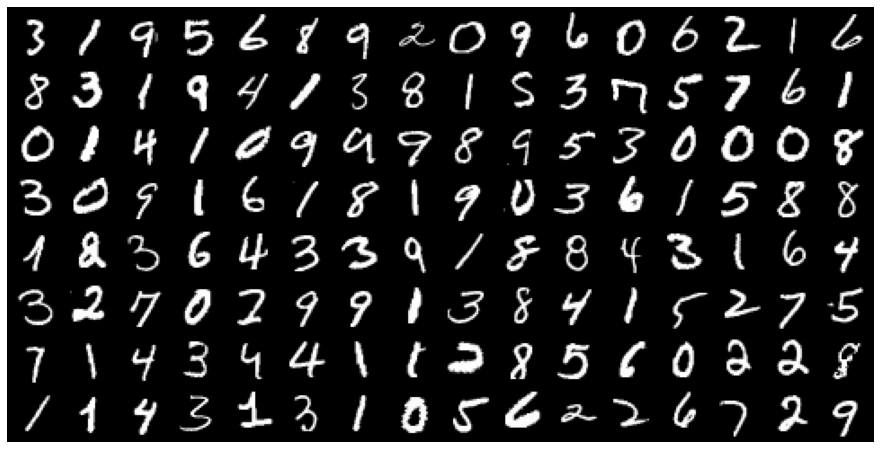

In [9]:
# Visualize batch of data 
for images, _ in train_dl:
    print('Images: ', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0)) # .permute rotates tensor, make_grid creates grid of images with columns1
    break

In [10]:
t = torch.rand(4, 4)
b = t.view(2, 8)
t, b, t.size(0)

(tensor([[0.2704, 0.9651, 0.2237, 0.4868],
         [0.0569, 0.4267, 0.4297, 0.9534],
         [0.3545, 0.7074, 0.5195, 0.9098],
         [0.9752, 0.1724, 0.6133, 0.1292]]),
 tensor([[0.2704, 0.9651, 0.2237, 0.4868, 0.0569, 0.4267, 0.4297, 0.9534],
         [0.3545, 0.7074, 0.5195, 0.9098, 0.9752, 0.1724, 0.6133, 0.1292]]),
 4)

In [11]:
def accuracy(outputs, labels):
    _, pred = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(pred == labels).item()/len(pred) )

In [12]:
class MnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) # Hidden layer
        self.linear2 = nn.Linear(hidden_size, output_size) # output layer
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1) # Flatten input
        out = self.linear1(xb)
        out = F.relu(out) # activation functon
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc' : acc}
    
    def validation_epoch(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
     
    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc:{:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

        
        

In [13]:
input_size = 784
hidden_size = 32
num_classes = 10

In [14]:
model = MnistModel(input_size, hidden_size=32, output_size=num_classes)

In [15]:
model

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [16]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [17]:
# Generating a few outputs
for images , labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print("Loss :" , loss.item())
    break
    
print("outputs.shape", outputs.shape)
print("sample-outputs", outputs[:2].data)

Loss : 2.299877405166626
outputs.shape torch.Size([128, 10])
sample-outputs tensor([[-0.1079,  0.0468,  0.0498, -0.1149,  0.2309, -0.0961,  0.0391,  0.4198,
          0.0643, -0.4725],
        [ 0.0405,  0.1677, -0.0839, -0.0226, -0.0142, -0.1439,  0.1144,  0.2468,
          0.0508, -0.2102]])


In [18]:
torch.cuda.is_available()

True

In [19]:
def  get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        

In [20]:
device = get_default_device()
device


device(type='cuda')

In [21]:
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [22]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    print(images)
    break

torch.Size([128, 1, 28, 28])
cuda:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [23]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, device)
            
    def __len__(self):
        return len(self.dl)

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [25]:
for xb, yb in val_dl:
    print("xb_device", xb.device)
    print("yb", yb)
    break
    

xb_device cuda:0
yb tensor([1, 7, 4, 4, 1, 3, 3, 2, 6, 5, 0, 4, 9, 9, 4, 0, 7, 4, 8, 2, 0, 9, 4, 8,
        5, 0, 3, 8, 5, 6, 9, 8, 2, 1, 0, 3, 9, 0, 5, 8, 7, 3, 2, 7, 5, 7, 6, 9,
        3, 4, 1, 8, 4, 6, 1, 5, 4, 3, 4, 0, 2, 1, 2, 1, 7, 8, 3, 4, 3, 1, 9, 4,
        2, 4, 9, 9, 4, 1, 4, 0, 0, 3, 6, 0, 5, 6, 1, 9, 4, 8, 5, 8, 2, 8, 4, 9,
        1, 3, 2, 1, 6, 6, 1, 9, 8, 0, 4, 9, 1, 3, 2, 6, 6, 4, 1, 0, 4, 1, 1, 8,
        8, 2, 3, 4, 4, 2, 7, 5, 9, 5, 4, 4, 2, 4, 2, 9, 8, 8, 4, 0, 3, 4, 5, 9,
        7, 6, 0, 4, 0, 4, 0, 4, 9, 6, 0, 9, 5, 9, 9, 7, 3, 8, 7, 1, 2, 9, 4, 5,
        6, 2, 5, 7, 5, 8, 3, 3, 0, 7, 4, 4, 9, 5, 2, 8, 2, 1, 6, 1, 3, 0, 0, 6,
        2, 0, 3, 2, 8, 1, 0, 1, 0, 6, 6, 3, 5, 6, 0, 9, 0, 9, 6, 2, 8, 2, 3, 3,
        7, 6, 6, 9, 4, 3, 8, 8, 5, 1, 6, 1, 0, 7, 2, 0, 0, 4, 0, 9, 8, 8, 1, 6,
        5, 6, 3, 3, 9, 4, 9, 2, 4, 8, 8, 8, 5, 1, 9, 0], device='cuda:0')


In [26]:
def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch(outputs)

def fit(epochs, lr, model, train_dl, val_dl, opt_fun= torch.optim.SGD):
    history= []
    optimizer = opt_fun(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training phase
        for batch in train_dl:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_dl)
       # print("Result: ", result)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [27]:
# Model on gpu
model = MnistModel(input_size, hidden_size=hidden_size, output_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [28]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': tensor(0.1062), 'val_loss': tensor(2.3023, device='cuda:0')}]

In [29]:
history += fit(5, 0.5, model, train_dl, val_dl)


Epoch[0], val_loss: 0.2434, val_acc:0.9288
Epoch[1], val_loss: 0.1904, val_acc:0.9426
Epoch[2], val_loss: 0.1492, val_acc:0.9549
Epoch[3], val_loss: 0.1525, val_acc:0.9519
Epoch[4], val_loss: 0.1790, val_acc:0.9465


Text(0.5, 1.0, 'Loss vs no of epoch')

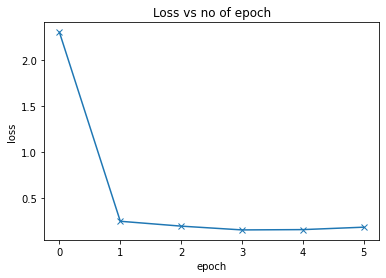

In [30]:
import matplotlib.pyplot as plt
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs no of epoch')



Text(0.5, 1.0, 'loss vs Accuracy')

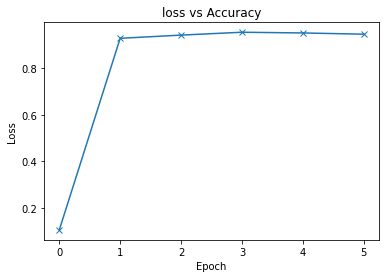

In [31]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss vs Accuracy')